This code is a 1D test with the time dependent example given in https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.html . 
<br> We use her Pytorch (because most used to it ) and we observe the evolution of the solution, especially if it gives the (if its unique, we don't know) analytical solution $u(x, t) = e^{-t}sin(\pi x)$.

In [1]:
#TIme dependent example of the presentation
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import os
os.environ['DDE_BACKEND'] = 'pytorch'
import torch

In [2]:
# Check if CUDA (GPU) is available and set default tensor type to cuda, but I haven't installed cuda yet
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("/////////////////\n Tensors type on GPU \n///////////////")
print("/////////////////\n Tensors type on CPU \n///////////////")

/////////////////
 Tensors type on CPU 
///////////////


In [3]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [5]:
def pde(x, y):
    # Most backends
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)

     
    return (
        dy_t
        - dy_xx
        + torch.exp(-x[:, 1:])
        * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    )


def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [6]:
#IC and BC
bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)

In [7]:
#Data and Model

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    solution=func,
    num_test=10000,
)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

Compiling model...
'compile' took 0.895506 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.53e+01, 2.27e-01, 2.59e-01]    [1.63e+01, 2.27e-01, 2.59e-01]    []  
1000      [3.32e-03, 3.90e-03, 6.31e-04]    [4.54e-03, 3.90e-03, 6.31e-04]    []  
2000      [7.61e-04, 3.06e-04, 1.60e-04]    [1.21e-03, 3.06e-04, 1.60e-04]    []  
3000      [2.93e-04, 6.39e-05, 4.90e-05]    [4.86e-04, 6.39e-05, 4.90e-05]    []  
4000      [2.94e-04, 2.66e-05, 3.14e-05]    [4.54e-04, 2.66e-05, 3.14e-05]    []  
5000      [2.84e-04, 3.29e-05, 3.17e-05]    [4.33e-04, 3.29e-05, 3.17e-05]    []  
6000      [6.72e-05, 7.20e-06, 1.64e-05]    [2.48e-04, 7.20e-06, 1.64e-05]    []  
7000      [8.36e-05, 6.37e-06, 1.48e-05]    [2.67e-04, 6.37e-06, 1.48e-05]    []  
8000      [5.96e-04, 5.64e-05, 2.40e-05]    [5.61e-04, 5.64e-05, 2.40e-05]    []  
9000      [1.79e-04, 1.89e-05, 1.44e-05]    [2.89e-04, 1.89e-05, 1.44e-05]    []  
10000     [2.86

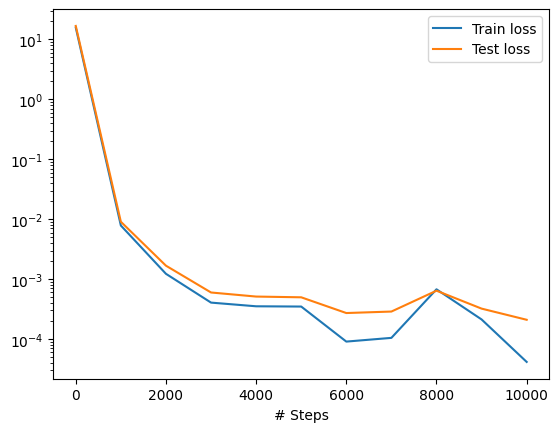

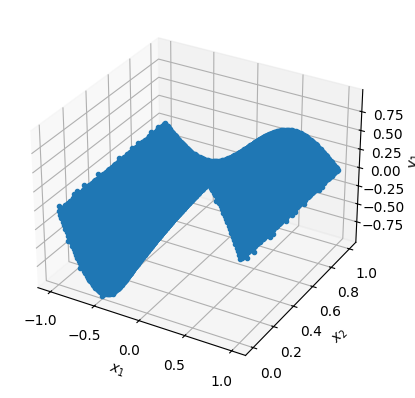

In [8]:
#Training 
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)
